# Classification of Alzhaimer through Brain MRI

## Importing Libraries

In [1]:
#Package imports.
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import random
import tensorflow as tf
from keras.utils import to_categorical
from keras import layers,models,losses
from sklearn import model_selection, metrics, preprocessing

In [2]:
#Import and mount Google Drive.
from google.colab import drive
#
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load Images

In [3]:
#Unzip the dataset file and store it in a folder called images.
#!unzip "/content/drive/MyDrive/MRI.zip" -d "/content/drive/MyDrive/images_MRI/"

In [4]:
!ls "/content/drive/MyDrive/images_MRI/Data"

'Mild Dementia'  'Moderate Dementia'  'Non Demented'  'Very mild Dementia'


In [5]:
#Read the images and get the data in a RGB and specific shape
folder_path = "/content/drive/MyDrive/images_MRI/Data/"
size = 128
data = []
labels = []
paths=[]
for folder in os.listdir(folder_path):
    for files in os.listdir(os.path.join(folder_path, folder)):
        if files.endswith("jpg"):
            labels.append(folder)
            #Create the image path.
            img_path = os.path.join(folder_path, folder, files)
            #Read in the images.
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            #Change BGR colour default from cv2 to RGB used in matplotlib.
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            #Resize the images.
            img = cv2.resize(img, (size, size))
            data.append(img)
            paths.append(img_path)

#Convert the data from a list to a NumPy array.
data_arr = np.array(data)

## Select by random sampling

In [6]:
#labels_np=np.array(labels)
#selected_indices={}
#for t in ['Mild Dementia','Non Demented','Very mild Dementia']:
#  selected_indices[t]=np.random.choice(np.where(labels_np==t)[0],500,replace=False)
#all_indices=np.hstack((selected_indices['Mild Dementia'],selected_indices['Non Demented'],selected_indices['Very mild Dementia'],np.where(labels_np=='Moderate Dementia')[0]))
#paths_to_delete=np.setdiff1d(np.array(paths),np.array(paths)[all_indices])
#for n in paths_to_delete:
#  os.remove(n)

## Data Analysis

In [7]:
#Check the size of the images
data_arr.shape

(1988, 128, 128, 3)

In [8]:
#Check all the classes
set(labels)

{'Mild Dementia', 'Moderate Dementia', 'Non Demented', 'Very mild Dementia'}

In [9]:
#Checking number of images from Mild Dementia
print('Mild Dementia:',labels.count("Mild Dementia"))
#Checking number of images from Moderate Dementia
print('Moderate Dementia:',labels.count("Moderate Dementia"))
#Checking number of images from Non Demented
print('Non Demented:',labels.count("Non Demented"))
#Checking number of images from Very mild Dementia
print('Very mild Dementia:',labels.count("Very mild Dementia"))

Mild Dementia: 500
Moderate Dementia: 488
Non Demented: 500
Very mild Dementia: 500


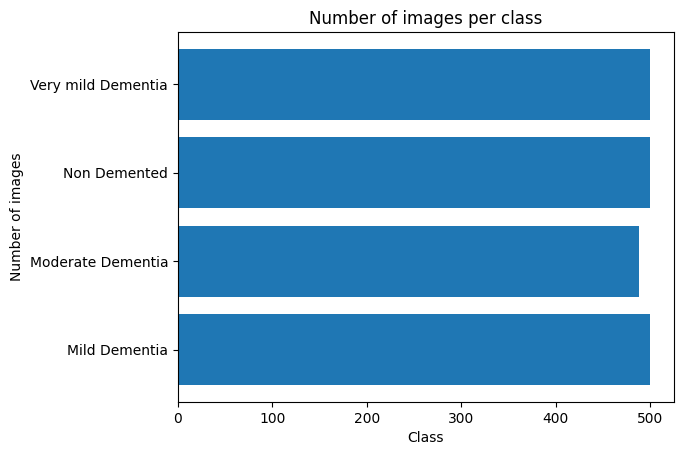

In [10]:
#Plotting horizontal barchart of the classes and images.
labels_plt=['Mild Dementia','Moderate Dementia','Non Demented','Very mild Dementia']
count=[labels.count('Mild Dementia'),labels.count('Moderate Dementia'),labels.count('Non Demented'),labels.count('Very mild Dementia')]
fig,ax=plt.subplots()
ax.barh(labels_plt,count)
ax.set_title('Number of images per class')
ax.set_xlabel('Class')
ax.set_ylabel('Number of images')
plt.show()

(-0.5, 127.5, 127.5, -0.5)

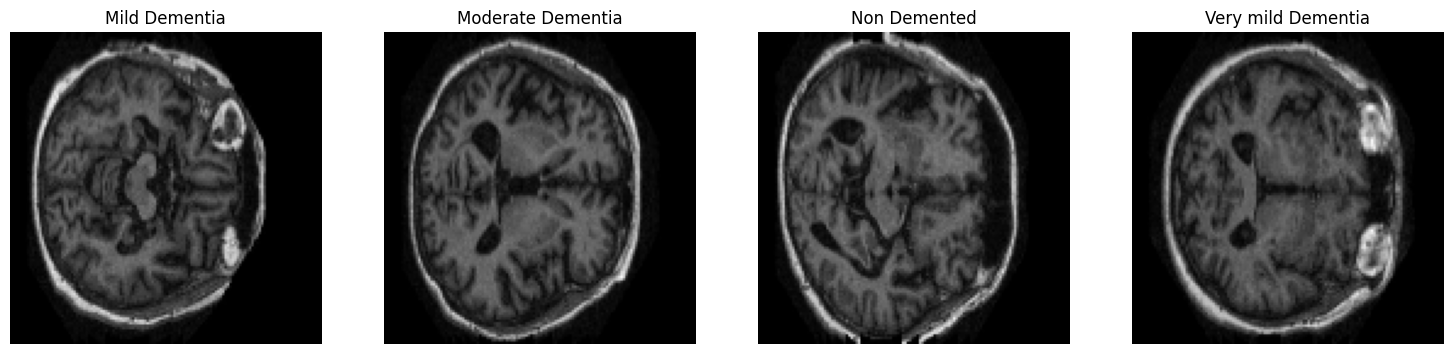

In [11]:
#Plot of examples by class of image
fig,ax=plt.subplots(1,4)
fig.set_size_inches(18.5, 10.5)
ax[0].imshow(data_arr[np.random.choice(range(1,500),1)[0]])
ax[0].set_title('Mild Dementia')
ax[0].axis('off')
ax[1].imshow(data_arr[np.random.choice(range(501,1000),1)[0]])
ax[1].set_title('Moderate Dementia')
ax[1].axis('off')
ax[2].imshow(data_arr[np.random.choice(range(1001,1500),1)[0]])
ax[2].set_title('Non Demented')
ax[2].axis('off')
ax[3].imshow(data_arr[np.random.choice(range(1501,1993),1)[0]])
ax[3].set_title('Very mild Dementia')
ax[3].axis('off')

## Preprocessing

### Create noise and data augmentation

In [12]:
#Function for create noise in the image.
def image_noise(image, noise_level):
    image = tf.cast(image, tf.int32)
    height, width, channels = image.shape[0], image.shape[1], image.shape[2]
    pixels_total = height * width * channels
    noise_added = pixels_total * noise_level
    noise_total=0
    #Get the percentage of noise
    while noise_total<noise_added:
      w=random.randint(1,3)
      h=random.randint(1,3)
      x=random.randint(1,width-w)
      y=random.randint(1,height-h)
      noise_total += w*h
      noise_to_add=w*h*3
      #Create the indices for introduce noise
      indices = [[j, k, i] for i in range(3) for j
                 in range(y, y + h) for k in range(x, x + w)]
      #Generate black noise
      noise_values = [np.random.randint(1,25)]*noise_to_add
      #Introduce noise
      image = tf.tensor_scatter_nd_update(image, indices, noise_values)
    return image

In [13]:
#Function for create noise in the image.
#def image_noise(image,noise_level):
#  height, width, channels = image.shape
#  pixels_total=height*width*channels
#  noise_added=int(pixels_total*noise_level)
#  noise_total=0
#  while noise_total<noise_added:
#    w=random.randint(1,3)
#    h=random.randint(1,3)
#    noise_total+=w*h
#    x=random.randint(0,width-w)
#    y=random.randint(0,height-h)
#    image[y:y+h,x:x+w,:]=np.random.randint(1,25)
#  return image

In [14]:
#Function for augment the images
def image_augment(image,seed):
    new_seed = tf.random.experimental.stateless_split(seed, num=1)[0, :]
    #Random left flip
    image = tf.image.stateless_random_flip_left_right(
       image, seed)
    #Random brightness change
    #image = tf.image.stateless_random_brightness(
       # image, max_delta=0.1, seed=new_seed)
    #Introduce hue
    #image = tf.image.stateless_random_hue(
       # image, 0.2, seed)
    #Introduce saturation
    #image = tf.image.stateless_random_saturation(
        #image, 0.3, 1.0, seed)
    #Adjust any value to the RGB range
    image = tf.clip_by_value(image, 0, 255)
    return image

In [15]:
#Set the random seed generator
rng = tf.random.Generator.from_seed(123, alg='philox')

In [16]:
#Function to prepare the images with noise and augmentation
def image_wrapper(image):
  #Generate random independent seed
  seed=rng.make_seeds(2)[0]
  #Augment data with the random seed
  image1=image_augment(image,seed)
  #Add noise
  image2=image_noise(image1,0.07)
  return image2,image1

In [17]:
#Get dataset tensorflow type
data=tf.data.Dataset.from_tensor_slices(data_arr)

In [18]:
#Preprocess the data
data_arr_processed=(data.shuffle(1000).map(image_wrapper))

In [19]:
#Get data preprocessed
data_arr_processed

<_MapDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.int32, name=None), TensorSpec(shape=(128, 128, 3), dtype=tf.uint8, name=None))>

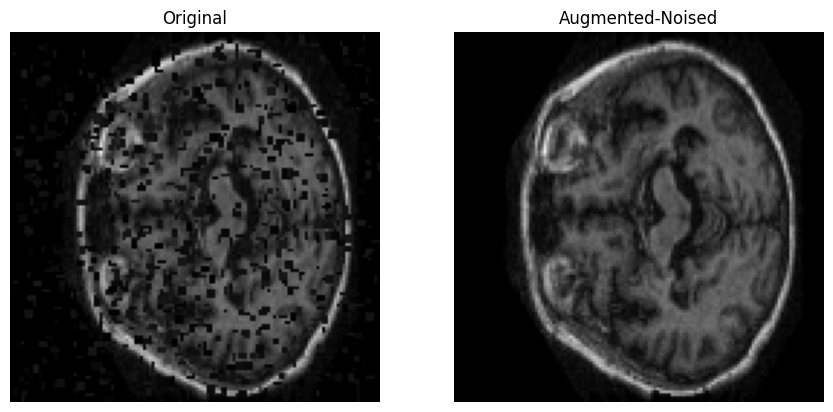

In [20]:
#Examples of
for item in data_arr_processed.take(1):
    fig,ax=plt.subplots(1,2)
    fig.set_size_inches(10.5, 7.5)
    ax[0].imshow(item[0].numpy())
    ax[0].set_title('Original')
    ax[0].axis('off')
    ax[1].imshow(item[1].numpy())
    ax[1].set_title('Augmented-Noised')
    ax[1].axis('off')

## U-Net Model

In [21]:
class DoubleConv(tf.keras.Model):
  def _init_(self, filters):
    super(DoubleConv, self).__init__()
      self.layer=tf.keras.Sequential(
      self.conv1 = tf.keras.layers.Conv2D(filters, 3, padding='same', activation='relu'),
      self.batch=tf.keras.layers.BatchNormalization(),
      self.conv2 = tf.keras.layers.Conv2D(filters, 3, padding='same', activation='relu'))
  def forward(self,x):
    return self.layer(x)

IndentationError: unexpected indent (<ipython-input-21-023a0ebbfc7f>, line 4)

In [ ]:
class Down(tf.keras.Model):
  def _init_(self, filters):
    super(Down, self).__init__()
    self.layer=tf.keras.Sequential(
      layers.MaxPooling2D((2,2),strides=2),
      DoubleConv(filters))
  def forward(self,x):
    return self.layer(x)

In [24]:

noised = layers.Input(shape=(128, 128, 3))

# Encoder
conv_1 = layers.Conv2D(64, (3,3), activation='relu', padding='same', strides=1)(noised)
batch_1 = layers.BatchNormalization()(conv_1)
conv_2 = layers.Conv2D(64, (3,3), activation='relu', padding='same', strides=1)(batch_1)
batch_2 = layers.BatchNormalization()(conv_2)
max_1 = layers.MaxPooling2D((2,2), strides=2)(conv_2)

conv_3 = layers.Conv2D(128, (3,3), activation='relu', padding='same', strides=1)(max_1)
batch_3 = layers.BatchNormalization()(conv_3)
conv_4 = layers.Conv2D(128, (3,3), activation='relu', padding='same', strides=1)(batch_3)
batch_4 = layers.BatchNormalization()(conv_4)
max_2 = layers.MaxPooling2D((2,2), strides=2)(batch_4)

conv_5 = layers.Conv2D(256, (3,3), activation='relu', padding='same', strides=1)(max_2)
batch_5 = layers.BatchNormalization()(conv_5)
conv_6 = layers.Conv2D(256, (3,3), activation='relu', padding='same', strides=1)(batch_5)
batch_6 = layers.BatchNormalization()(conv_6)
max_3 = layers.MaxPooling2D((2,2), strides=2)(batch_6)

conv_7 = layers.Conv2D(512, (3,3), activation='relu', padding='same', strides=1)(max_3)
batch_7 = layers.BatchNormalization()(conv_7)
conv_8 = layers.Conv2D(512, (3,3), activation='relu', padding='same', strides=1)(batch_7)
batch_8 = layers.BatchNormalization()(conv_8)
max_4 = layers.MaxPooling2D((2,2), strides=2)(batch_8)

conv_9 = layers.Conv2D(1024, (3,3), activation='relu', padding='same', strides=1)(max_4)
batch_9 = layers.BatchNormalization()(conv_9)
conv_10 = layers.Conv2D(1024, (3,3), activation='relu', padding='same', strides=1)(batch_9)
batch_10 = layers.BatchNormalization()(conv_10)

# Decoder
deconv_1 = layers.Conv2DTranspose(512, (3,3), activation='relu', padding='same', strides=2)(batch_10)
concat_1 = layers.Concatenate()([conv_8, deconv_1])
conv_11 = layers.Conv2D(512, (3,3), activation='relu', padding='same', strides=1)(concat_1)
batch_11 = layers.BatchNormalization()(conv_11)

deconv_2 = layers.Conv2DTranspose(256, (3,3), activation='relu', padding='same', strides=2)(batch_11)
concat_2 = layers.Concatenate()([conv_6, deconv_2])
conv_13 = layers.Conv2D(256, (3,3), activation='relu', padding='same', strides=1)(concat_2)
batch_13 = layers.BatchNormalization()(conv_13)

deconv_3 = layers.Conv2DTranspose(128, (3,3), activation='relu', padding='same', strides=2)(batch_13)
concat_3 = layers.Concatenate()([conv_4, deconv_3])
conv_15 = layers.Conv2D(128, (3,3), activation='relu', padding='same', strides=1)(concat_3)
batch_15 = layers.BatchNormalization()(conv_15)

deconv_4 = layers.Conv2DTranspose(64, (3,3), activation='relu', padding='same', strides=2)(batch_15)
concat_4 = layers.Concatenate()([conv_2, deconv_4])
conv_17 = layers.Conv2D(64, (3,3), activation='relu', padding='same', strides=1)(concat_4)
batch_17 = layers.BatchNormalization()(conv_17)

output = layers.Conv2D(3, (1,1), activation='sigmoid', padding='same', strides=1)(batch_17)

model = models.Model(inputs=noised, outputs=output)

In [25]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mse')

In [22]:
data_train,data_test=model_selection.train_test_split(data_arr/255., test_size=0.2, random_state=42)

In [23]:
data_train_processed=tf.data.Dataset.from_tensor_slices(data_train).shuffle(100).map(image_wrapper).batch(16)
data_test_processed=tf.data.Dataset.from_tensor_slices(data_test).shuffle(100).map(image_wrapper).batch(16)

In [ ]:
model.fit(data_train_processed,epochs=10,validation_data=data_test_processed)

Epoch 1/10
 84/100 ━━━━━━━━━━━━━━━━━━━━ 7:37 29s/step - loss: 0.1513

In [ ]:
test_original=np.expand_dims(data_arr[10]/255.,axis=0)
test_noise=np.expand_dims(image_noise(data_arr[10],0.07).numpy()/255.,axis=0)

In [ ]:
test_denoised=model.predict(test_noise)

In [ ]:
test_original.shape

In [ ]:
test_denoised.shape

In [ ]:
fig,ax=plt.subplots(1,3)
fig.set_size_inches(10.5, 7.5)
ax[0].imshow(test_original[0])
ax[0].set_title('Original')
ax[0].axis('off')
ax[1].imshow(test_denoised[0])
ax[1].set_title('Denoised')
ax[1].axis('off')
ax[2].imshow(test_noise[0])
ax[2].set_title('Noised')
ax[2].axis('off')

In [24]:
conv_encoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(128, 128, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), padding='same')
])
conv_decoder = tf.keras.Sequential([
    tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=2, activation='relu', padding='same'),
    tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same'),
    tf.keras.layers.Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same'),
    tf.keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')
])
conv_ae = tf.keras.Sequential([conv_encoder, conv_decoder])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [ ]:
conv_ae.compile(loss="mse", optimizer="nadam")
conv_ae.fit(data_train_processed, epochs=10,validation_data=data_test_processed)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 181s 2s/step - loss: 0.0415 - val_loss: 0.0259
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 205s 2s/step - loss: 0.0197 - val_loss: 0.0255
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - loss: 0.0196 - val_loss: 0.0251
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 171s 2s/step - loss: 0.0195 - val_loss: 0.0256
Epoch 5/10
 30/100 ━━━━━━━━━━━━━━━━━━━━ 1:45 2s/step - loss: 0.0196

KeyboardInterrupt: 

In [ ]:
test_denoised=conv_ae.predict(test_noise)

In [ ]:
fig,ax=plt.subplots(1,3)
fig.set_size_inches(10.5, 7.5)
ax[0].imshow(test_original[0])
ax[0].set_title('Original')
ax[0].axis('off')
ax[1].imshow(test_denoised[0])
ax[1].set_title('Denoised')
ax[1].axis('off')
ax[2].imshow(test_noise[0])
ax[2].set_title('Noised')
ax[2].axis('off')